## Dataset Setup

In [9]:
!pip install -q kaggle

Import the kaggle.json file here

In [10]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanjaybalamurugan29","key":"9ce3a5b0166d6eca5a1c4d940a623d71"}'}

In [11]:
!mkdir -p ~/.kaggle

In [12]:
!cp kaggle.json ~/.kaggle/

In [13]:
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d thomasfermi/lane-detection-for-carla-driving-simulator

100% 1.87G/1.88G [01:41<00:00, 18.7MB/s]
100% 1.88G/1.88G [01:41<00:00, 19.8MB/s]


In [15]:
!unzip lane-detection-for-carla-driving-simulator.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2318.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2319.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_232.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2320.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2321.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2322.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2323.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2324.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2325.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2326.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2327.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2328.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame

### Car Lane Detection Using NumPy and OpenCV in Python - Enhance driver assistance systems with a lane detection algorithm for improved vehicle navigation.

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [36]:
DATA_DIR = '/content/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_label')

In [32]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [33]:
from torch.utils.data import DataLoader, Dataset
from torch import LongTensor

In [34]:
import re
import cv2

class CarlaLanesDataset(Dataset):
    """ Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['background', 'left_marker', 'right_marker']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        #random.shuffle(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        get_label_name = lambda fn: re.sub(".png", "_label.png", fn)
        self.masks_fps = [os.path.join(masks_dir, get_label_name(image_id)) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, LongTensor(mask)

    def __len__(self):
        return len(self.ids)

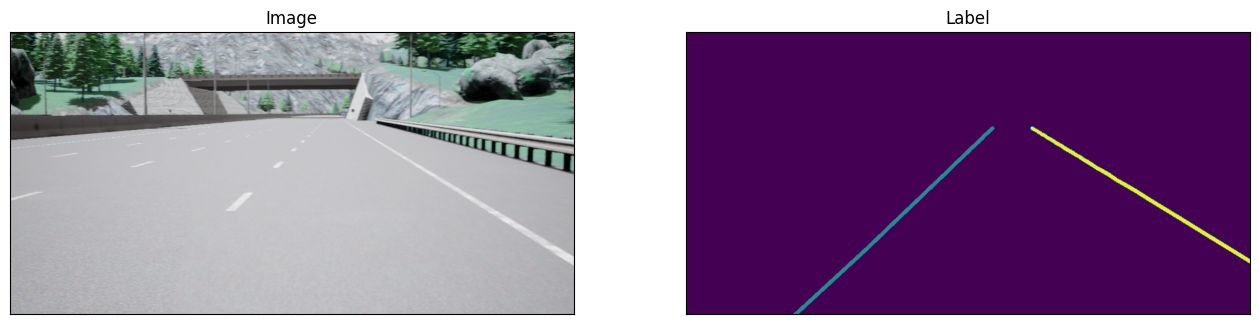

In [37]:
dataset = CarlaLanesDataset(x_train_dir, y_train_dir, classes=CarlaLanesDataset.CLASSES)

image, mask = dataset[4] # get some sample
visualize(
    image=image,
    label = mask
)

In [38]:
import albumentations as albu

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


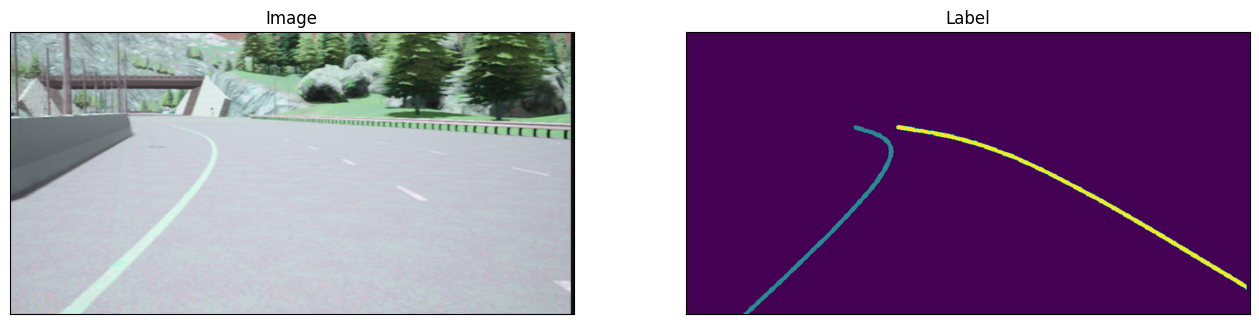

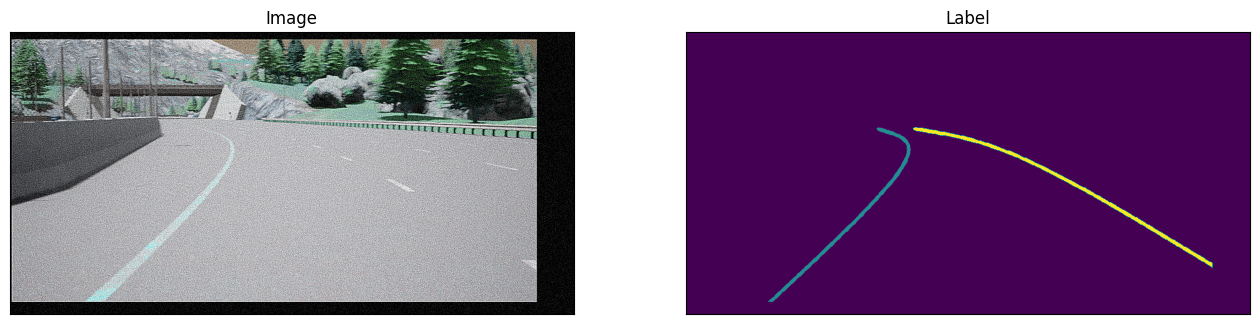

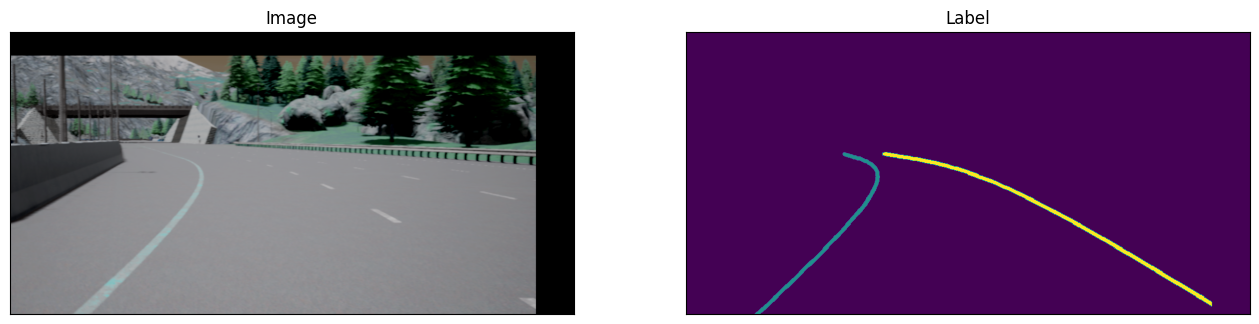

In [39]:
def get_training_augmentation():
    train_transform = [
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=0),

        albu.IAAAdditiveGaussianNoise(p=0.2),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.6,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.6,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    return None

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)
#### Visualize resulted augmented images and masks

augmented_dataset = CarlaLanesDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    classes=CarlaLanesDataset.CLASSES,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, label=mask)

In [42]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=0ce16e6c47a986f1b99730fdc15240869f0051e8674b3828b47d3fe1eb235e91
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=8529260302cd151015d45a07e6f07584ced718bf9cd8ed9a86925f3b973d8b68
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [43]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [44]:
loss_string = 'multi_dice_loss'

ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CarlaLanesDataset.CLASSES),
    activation=ACTIVATION,
    #encoder_depth = 4
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 190MB/s]


In [45]:
train_dataset = CarlaLanesDataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

valid_dataset = CarlaLanesDataset(
    x_valid_dir,
    y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CarlaLanesDataset.CLASSES,
)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [46]:
bs_train = 8
bs_valid = 8
train_loader = DataLoader(train_dataset, batch_size=bs_train, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=bs_valid, shuffle=False)

In [47]:
from segmentation_models_pytorch.utils import base
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import Accuracy

label_left = CarlaLanesDataset.CLASSES.index('left_marker')
label_right = CarlaLanesDataset.CLASSES.index('right_marker')

class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = DiceLoss()
        self.BinaryDiceLossRight = DiceLoss()

    def forward(self, y_pr, y_gt):
        #print("shape y_pr:", y_pr.shape)
        #print("shape y_gt:", y_gt.shape)
        # ypr.shape=bs,3,512,1024, ygt.shape=bs,512,1024
        left_gt = (y_gt == label_left)
        right_gt = (y_gt == label_right)
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:,label_left,:,:] , left_gt)
        loss_right = self.BinaryDiceLossRight.forward(y_pr[:,label_right,:,:] , right_gt)
        return (loss_left + loss_right)*0.5

In [48]:
import torch

metrics = []
loss = MultiDiceLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

In [49]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)
best_loss = 1e10

for i in range(0, 5):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if best_loss > valid_logs[loss_string]:
        best_loss = valid_logs[loss_string]
        torch.save(model, './best_model_{}.pth'.format(loss_string))
        print('Model saved!')

    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 17/17 [00:09<00:00,  1.79it/s, multi_dice_loss - 0.2241]
Model saved!

Epoch: 1
valid: 100%|██████████| 17/17 [00:08<00:00,  1.96it/s, multi_dice_loss - 0.1654]
Model saved!

Epoch: 2
valid: 100%|██████████| 17/17 [00:09<00:00,  1.82it/s, multi_dice_loss - 0.1584]
Model saved!

Epoch: 3
valid: 100%|██████████| 17/17 [00:09<00:00,  1.80it/s, multi_dice_loss - 0.1525]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 17/17 [00:09<00:00,  1.83it/s, multi_dice_loss - 0.1235]
Model saved!


In [50]:
best_model = torch.load('./best_model_multi_dice_loss.pth')

In [51]:
test_best_model = True
if test_best_model:
    # create test dataset
    test_dataset = CarlaLanesDataset(
        x_valid_dir,
        y_valid_dir,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocessing_fn),
        classes=CarlaLanesDataset.CLASSES,
    )

    test_dataloader = DataLoader(test_dataset)

    # evaluate model on test set
    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 129/129 [00:08<00:00, 14.45it/s, multi_dice_loss - 0.1208]


In [52]:
# test dataset without transformations for image visualization
test_dataset_vis = CarlaLanesDataset(
    x_valid_dir, y_valid_dir,
    classes=CarlaLanesDataset.CLASSES,
    preprocessing=get_preprocessing(preprocessing_fn)
)

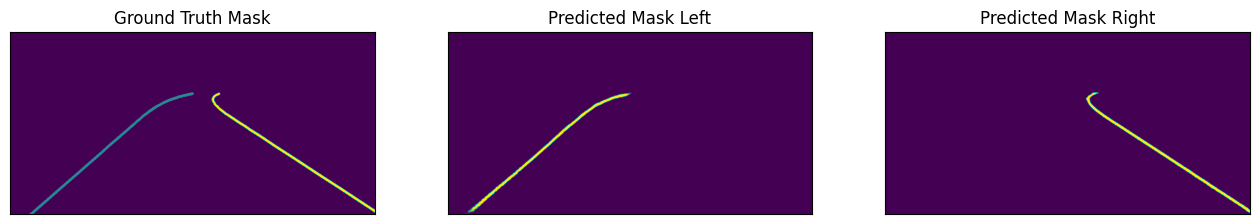

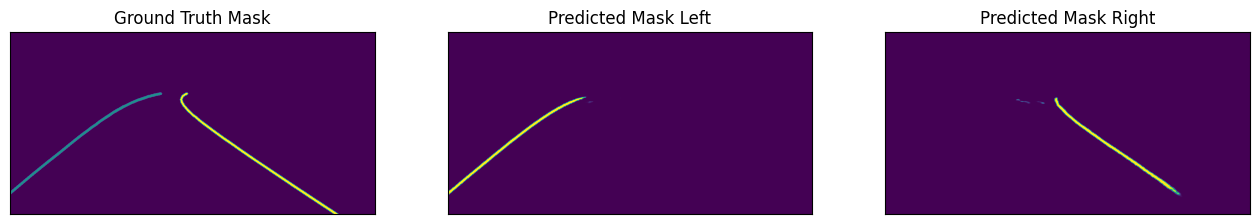

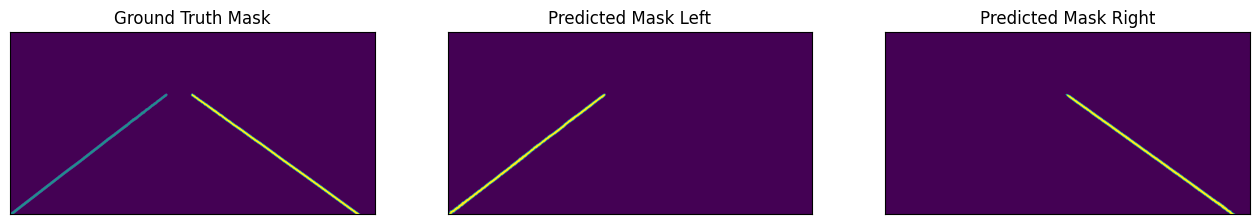

In [53]:
for i in range(3):
    n = np.random.choice(len(test_dataset_vis))

    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset_vis[n]

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask_left = best_model.predict(x_tensor)[0,1,:,:]
    pr_mask_left = (pr_mask_left.cpu().numpy())

    pr_mask_right = best_model.predict(x_tensor)[0,2,:,:]
    pr_mask_right = (pr_mask_right.cpu().numpy())

    visualize(
        ground_truth_mask=gt_mask,
        predicted_mask_left=pr_mask_left,
        predicted_mask_right=pr_mask_right
    )